![](https://www.finplus.co.in/wp-content/uploads/2017/10/Top-Categories-In-Online-Retail-In-India.jpg)

## Overview
Online retail is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

## Business Goal
We aim to segement the Customers based on RFM (Recency/Frequency/Monetary) so that the company can target its customers efficiently.

## What Is Recency, Frequency, Monetary Value (RFM)?

Recency, frequency, monetary value is a marketing analysis tool used to identify a company's or an organization's best customers by using certain measures. The RFM model is based on three quantitative factors:

- Recency: How recently a customer has made a purchase
- Frequency: How often a customer makes a purchase
- Monetary Value: How much money a customer spends on purchases

RFM analysis numerically ranks a customer in each of these three categories, generally on a scale of 1 to 5 (the higher the number, the better the result). The "best" customer would receive a top score in every category.

1. [Import packages](#1)
1. [Load data](#2)
1. [ Data Cleaning](#3)
1. [Data Preparation](#4)
1. [Build the model](#5)
1. [First Submission to Kaggle](#6)
1. [OverSampling methods](#7)
1. [GridSearchCV](#8)
1. [Ensemble methods](#9)
1. [Deep Learning methods](#10)

<a id="1"></a> <br>
## Import packages

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt


import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

<a id="2"></a> <br>
## Load data

In [21]:
retail = pd.read_csv('OnlineRetail.csv', sep=",", encoding="ISO-8859-1", header=0)

retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [10]:
retail.shape

(541909, 8)

In [12]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [13]:
retail.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


<a id="3"></a> <br>
## Data Cleaning

Let's see if there are any missing values :

In [15]:
retail.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

As we can see, there are somme missing values in "Description" and "Customer Id". We need those variable later so we droping row having missing values.

In [22]:
retail = retail.dropna()
retail.shape

(406829, 8)

In [23]:
# Changing the datatype of Customer Id as per Business understanding

retail['CustomerID'] = retail['CustomerID'].astype(str)

<a id="4"></a> <br>
## Data Preparation

We are going to analysis the Customers based on below 3 factors:
- R (Recency): Number of days since last purchase
- F (Frequency): Number of transactions
- M (Monetary): Total amount of transactions (revenue contributed)

Let's build our three variables, first monetary :

In [26]:
# Monetary (M)

retail['Amount'] = retail['Quantity']*retail['UnitPrice']
rfm_m = retail.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [29]:
# Frequency (F)

rfm_f = retail.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


Let's merge our two df to have Monetary and Frequency together.

In [30]:
# Merging the two dfs

rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


Now let's build our last variable : Recency (R).

But in order to do that, we need a proper datatype for ou variable date.

In [85]:
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d-%m-%Y %H:%M')

Let's compute the maximum date to know the last transaction date

In [32]:
max_date = max(retail['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

And let's compute the difference between max date and transaction date

In [33]:
retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


And now, in order to get the recency of customer, we need to compute the last transaction date.

In [34]:
rfm_p = retail.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,CustomerID,Diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [35]:
# Extract number of days only

rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


And finally, merge our dataframes to get the final RFM dataframe :

In [36]:
rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


That's it we have our three variable : R, F and M ! But before we proceed to our model, we need to do some stuff, like handle outliers and rescaling.

There are 2 types of outliers : 
- Statistical
- Domain specific

We will treat them as it can skew our dataset. So let's analyse the outliers of Amount Frequency and Recency :

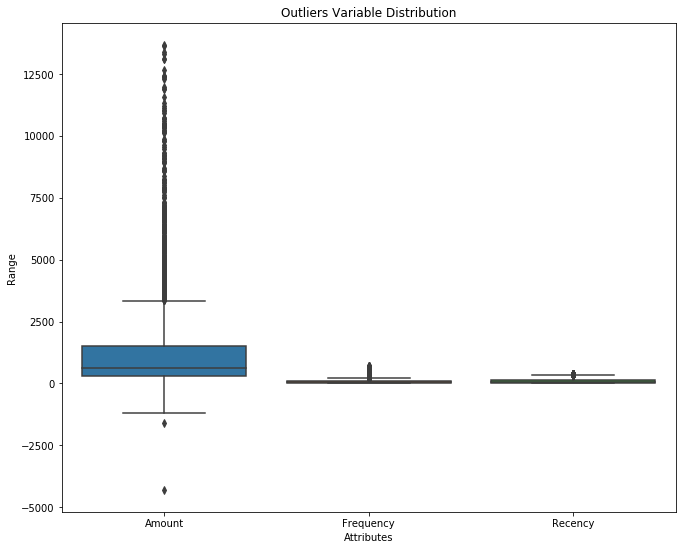

In [64]:
attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [11,9]

sns.boxplot(data = rfm[attributes])
plt.title("Outliers Variable Distribution")
plt.ylabel("Range")
plt.xlabel("Attributes");

In [39]:
# Removing (statistical) outliers for Amount
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

Now that we have dealt with outliers, we can focus on rescaling the attributes

It is extremely important to rescale the variables so that they have a comparable scale. There are two common ways of rescaling:

- Min-Max scaling
- Standardisation (mean-0, sigma-1)

Here, we will use Standardisation Scaling.

In [40]:
# Rescaling the attributes

rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape


C:\Users\Evan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Evan\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


(4293, 3)

In [41]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


We are done with the preprocessing, we can move on to the next step !

<a id="5"></a> <br>
## Build the model

**K-Means Clustering**

K-means clustering is one of the simplest and popular unsupervised machine learning algorithms.

The algorithm works as follows:

- First we initialize k points, called means, randomly.
- We categorize each item to its closest mean and we update the mean’s coordinates, which are the averages of the items categorized in that mean so far.
- We repeat the process for a given number of iterations and at the end, we have our clusters.

First, we need to find the optimal number of Clusters, this is a fundamental step for any unsupervised algorithm. For this we have the notorious Elbow methods. We build the Elbow curve to get the right number of Clusters :

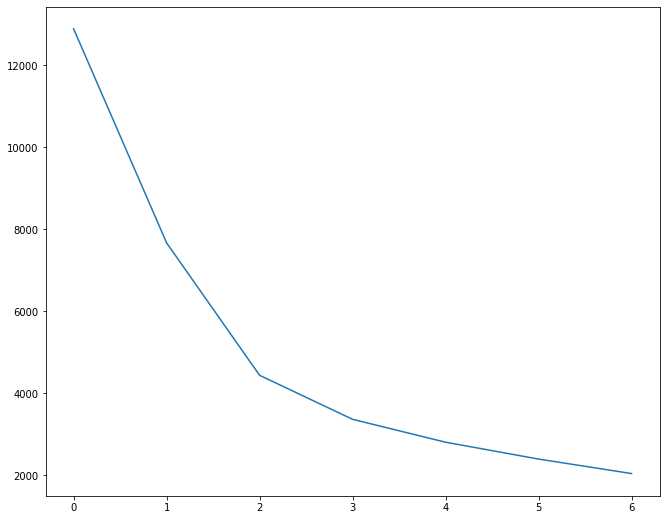

In [66]:
cost = []

for k in range(1,8):
    kmeans = KMeans(n_clusters = k).fit(rfm_df_scaled)
    cost.append(kmeans.inertia_)
    
plt.plot(cost);

We see that our curve decreases significantly until the number of clusters is 3 and then does not change as much anymore. This means that the optimal number of clusters is 3.  

We can also visualise the silhouette analysis to see if 3 is the right choice. Silhouette score is a metric where the value range lies between -1 to 1.

Values close to -1 correspond to bad clustering results while values closer to 1 correspond to dense, well-defined clusters. Therefore, the higher the silhouette value is, the better the results from clustering.

In [87]:
for i in range(2,8):
    kmeans = KMeans(n_clusters = i, max_iter = 50).fit(rfm_df_scaled)
    cluster_label = kmeans.labels_
    
    
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_label)
    
    print('For n_cluster ={0}, the silhouette score is {1}'. format(i, silhouette_avg ))

For n_cluster =2, the silhouette score is 0.5415858652525395
For n_cluster =3, the silhouette score is 0.5084896296141937
For n_cluster =4, the silhouette score is 0.48184961525078546
For n_cluster =5, the silhouette score is 0.464237557709883
For n_cluster =6, the silhouette score is 0.4169897163641209
For n_cluster =7, the silhouette score is 0.41750842975562236


As we can see, 3 seems to be a nice pick. We could also choose 2 but just two type of customers seems quite low. I think 3 is more efficient. Let's build our final kmeans model.

In [47]:
# Final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

print(kmeans.labels_)

[2 1 0 ... 2 0 0]


Now, I just need to assign the label.

In [51]:
rfm['Cluster'] = kmeans.labels_
rfm.head()

,CustomerID,Amount,Frequency,Recency,cluster,Cluster
0,12346.0,0.00,2,325,2,2
1,12347.0,4310.00,182,1,1,1
2,12348.0,1797.24,31,74,0,0
3,12349.0,1757.55,73,18,0,0
4,12350.0,334.40,17,309,2,2


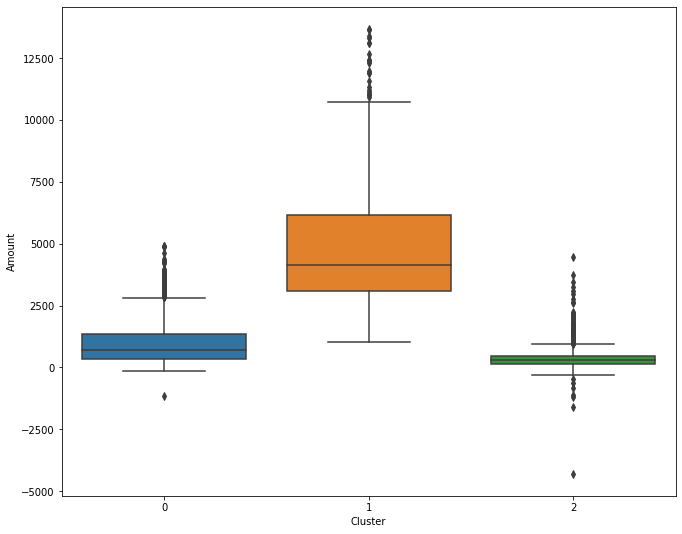

In [67]:
# Box plot to visualize Cluster vs Frequency

sns.boxplot(x='Cluster', y='Amount', data=rfm);

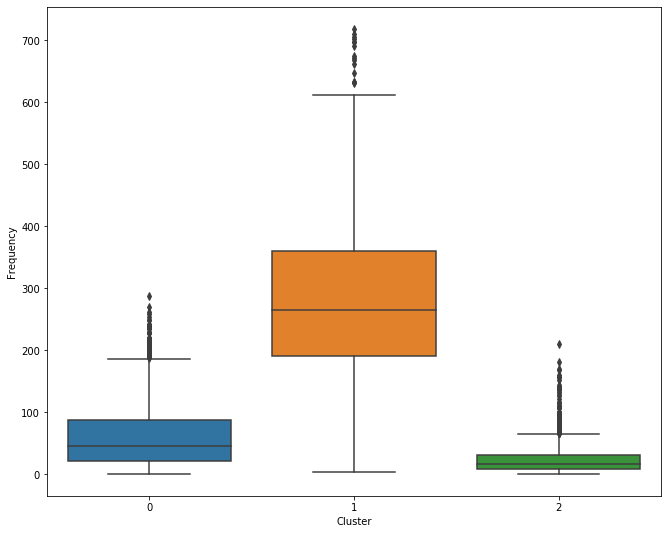

In [68]:
# Box plot to visualize Cluster vs Frequency

sns.boxplot(x='Cluster', y='Frequency', data=rfm);

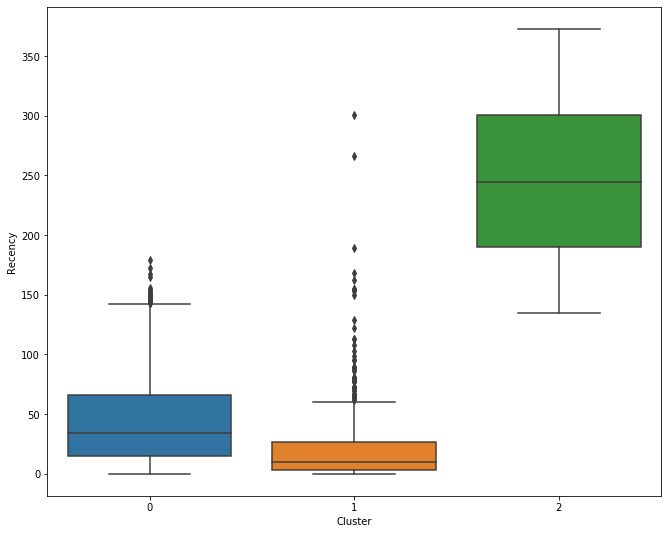

In [69]:
# Box plot to visualize Cluster vs Recency

sns.boxplot(x='Cluster', y='Recency', data=rfm);

K-Means Clustering with 3 Cluster :

- Customers with Cluster 1 are the customers with high amount of transactions as compared to other customers.
- Customers with Cluster  1 are frequent buyers.
- Customers with Cluster Id 2 are not recent buyers and hence least of importance from business point of view.

### Hierarchical clustering 

 Hierarchical clustering is a unsupervised partitionning method. This method is bottom-up, because she start with each individual with is own class, and then more and more reunited.
 
![SegmentLocal](DkjOLy.gif "segment")

The name hierarchical of this classification comes from the fact that it produces a hierarchy, the set of clusters at all stages of the algorithm, such as at the top of the hierarchy, when we group in order to obtain a single cluster , all the points are grouped together and at the bottom of the hierarchy, all the points are found alone.

This process is perfectly observed with dendogram. So let's make our dendogram and see how it goes.

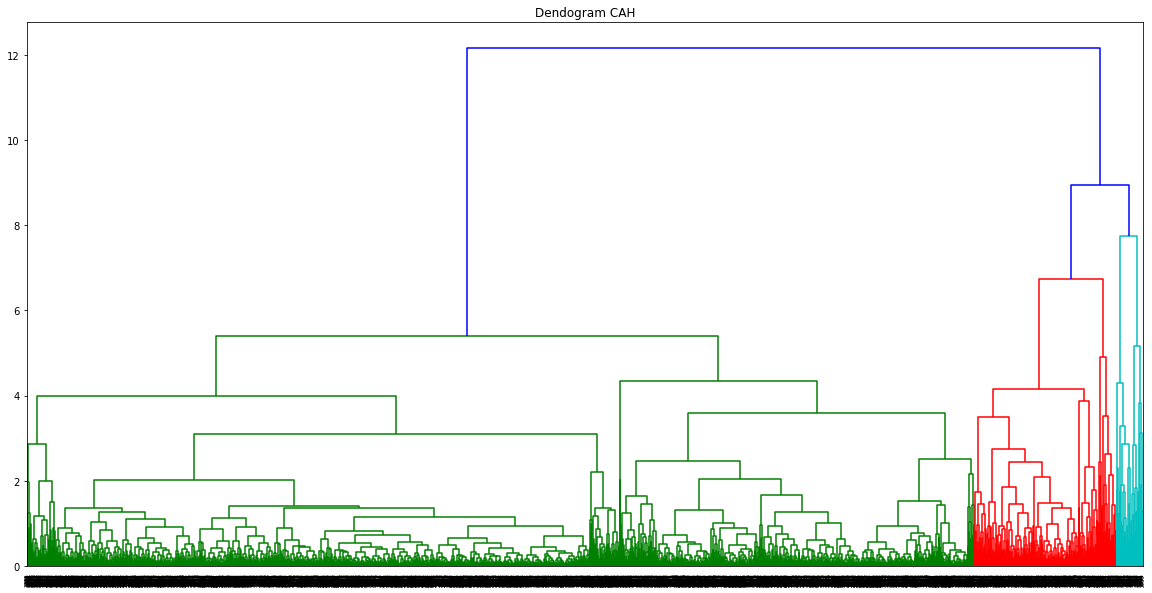

In [72]:
plt.figure(figsize=(20, 10))

Z = linkage(rfm_df_scaled, method="complete", metric='euclidean')

dendrogram(Z)
plt.title('Dendogram CAH')
plt.show()

Once the different clusters have been obtained, it is possible to choose the optimal number of clusters to use by 'cutting' the tree (the dendrogram) at a certain height. The number of clusters capable of better representing the different groups can be chosen by observing the dendrogram. It is often relevant to choose the partitioning corresponding to the largest jump between two consecutive clusters. Here it's three !

So, it's time to build a algorithm with 3 clusters. We will use AgglomerativeClustering.

In [74]:
clf = AgglomerativeClustering(n_clusters = 3)
clf.fit(rfm_df_scaled)

labels = clf.labels_

In [77]:
for i in range(2,8):
    clf = AgglomerativeClustering(n_clusters = i).fit(rfm_df_scaled)
    cluster_label = clf.labels_
    
    
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_label)
    
    print('For n_cluster ={0}, the silhouette score is {1}'. format(i, silhouette_avg ))

For n_cluster =2, the silhouette score is 0.5788705653522203
For n_cluster =3, the silhouette score is 0.4643083907731691
For n_cluster =4, the silhouette score is 0.4051843429630831
For n_cluster =5, the silhouette score is 0.41511266107278166
For n_cluster =6, the silhouette score is 0.39121274591666594
For n_cluster =7, the silhouette score is 0.3945018547696076


It seems that 3 was a good pick. So let's assign our label to our dataframe and analyse our result.

In [75]:
# Assign cluster labels

rfm['Cluster_Labels'] = labels
rfm.head()

,CustomerID,Amount,Frequency,Recency,cluster,Cluster,Cluster_Labels
0,12346.0,0.00,2,325,2,2,2
1,12347.0,4310.00,182,1,1,1,1
2,12348.0,1797.24,31,74,0,0,0
3,12349.0,1757.55,73,18,0,0,0
4,12350.0,334.40,17,309,2,2,2


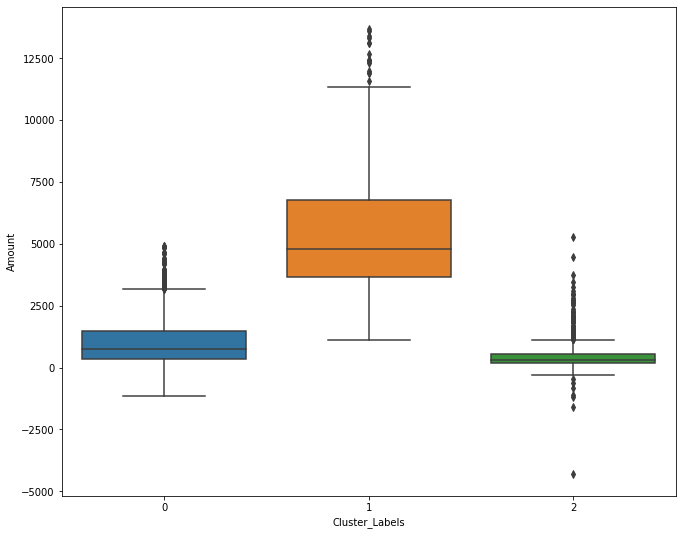

In [79]:
# Plot Cluster Id vs Amount

sns.boxplot(x='Cluster_Labels', y='Amount', data=rfm);

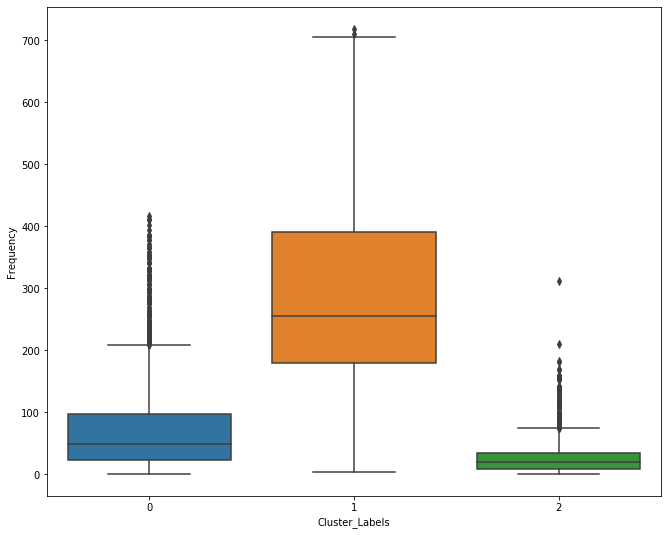

In [81]:
# Plot Cluster Id vs Frequency

sns.boxplot(x='Cluster_Labels', y='Frequency', data=rfm);

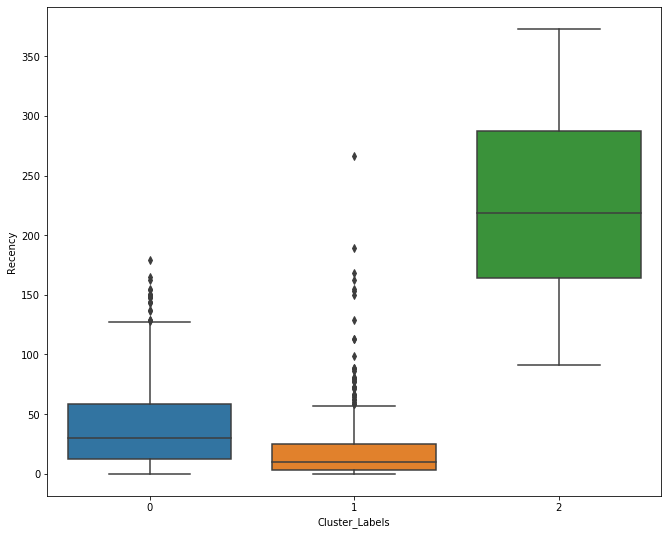

In [82]:
# Plot Cluster Id vs Recency

sns.boxplot(x='Cluster_Labels', y='Recency', data=rfm);

Hierarchical Clustering with 3 Cluster Labels

Customers with Cluster_Labels 1 are the customers with high amount of transactions as compared to other customers.
Customers with Cluster_Labels 1 are frequent buyers.
Customers with Cluster_Labels 2 are not recent buyers and hence least of importance from business point of view.

It seems that with both K-means Clustering and Hierarchical Clustering , the customers with label 1 are the most important form business point of view